In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from matplotlib.patches import Patch
from scipy.stats import uniform
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
url = 'https://raw.githubusercontent.com/brainhack-school2020/Biosignal-Emotions-BHS-2020/master/Data/DREAMER_Preprocessed_NotTransformed_NotThresholded.csv'
df = pd.read_csv(url, sep=',', index_col=0)

In [0]:
data = df.loc[(df['Target_Emotion'] == 'anger') | (df['Target_Emotion'] == 'fear') | (df['Target_Emotion'] == 'calmness')].copy()

In [0]:
data['Stress_bin'] = data['Target_Emotion'].map({'anger': 1, 'fear': 1, 'calmness': 0})

In [0]:
group_kfold = GroupKFold(n_splits=10)
X = data.loc[:,'psdtheta_1':'SampEn'].to_numpy()
y = data['Stress_bin'].to_numpy()
groups = data['Participant'].to_numpy()
for train_index, test_index in group_kfold.split(X, y, groups):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [0]:
def run_clf(clf):

  cv = GroupKFold(n_splits=10)

  tprs = []
  aucs = []
  score = []
  runtime = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots()
  for fold, (train, test) in enumerate(cv.split(X, y, groups)):
      clf.fit(X[train], y[train])
      start = time.time()
      score.append(clf.score(X_test, y_test))
      runtime.append(time.time() - start)
      viz = plot_roc_curve(clf, X[test], y[test],
                          name='ROC fold {}'.format(fold+1),
                          alpha=0.3, lw=1, ax=ax)
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                  label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic")
  ax.legend(loc="lower right")
  plt.show()
  return score, runtime

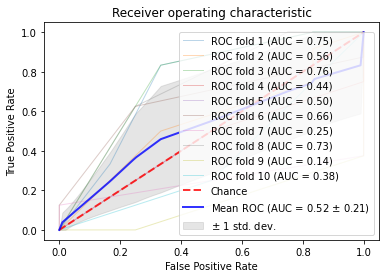

['Name', 'Nearest Neighbors', 'Mean_Score', 0.8666666666666666, 'Mean_Runtime', 0.0015833139419555663]


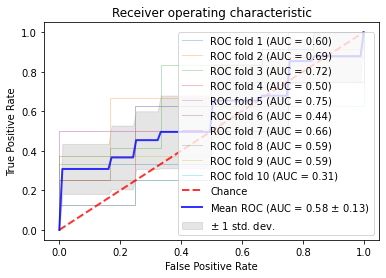

['Name', 'Linear SVM', 'Mean_Score', 0.6666666666666667, 'Mean_Runtime', 0.0005755901336669921]


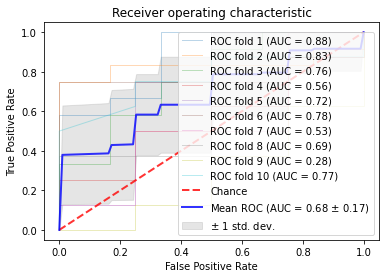

['Name', 'RBF SVM', 'Mean_Score', 0.8666666666666666, 'Mean_Runtime', 0.0006256580352783203]


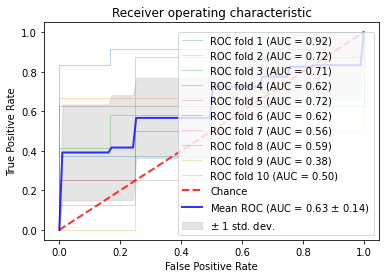

['Name', 'Gaussian Process', 'Mean_Score', 0.7, 'Mean_Runtime', 0.0010608434677124023]


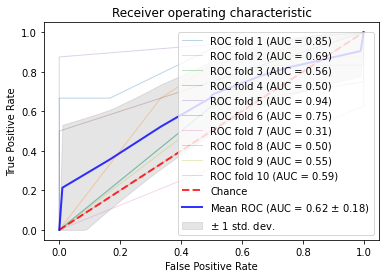

['Name', 'Decision Tree', 'Mean_Score', 0.8916666666666666, 'Mean_Runtime', 0.0005658388137817383]


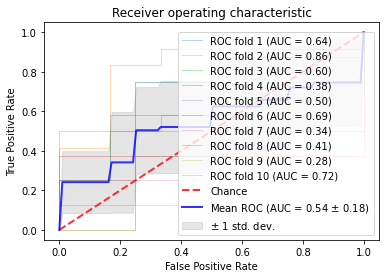

['Name', 'Random Forest', 'Mean_Score', 0.8583333333333332, 'Mean_Runtime', 0.00170745849609375]


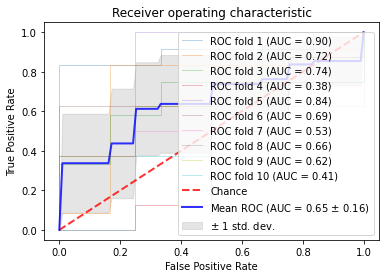

['Name', 'Neural Net', 'Mean_Score', 0.7083333333333334, 'Mean_Runtime', 0.0008667230606079102]


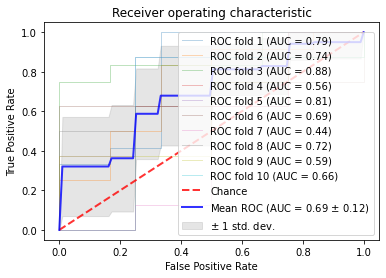

['Name', 'AdaBoost', 'Mean_Score', 0.9833333333333334, 'Mean_Runtime', 0.006273078918457031]


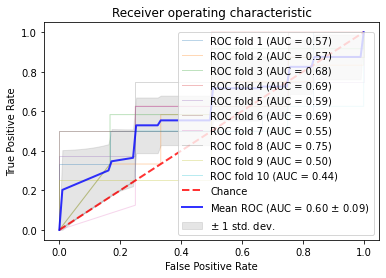

['Name', 'Naive Bayes', 'Mean_Score', 0.5916666666666667, 'Mean_Runtime', 0.0005769968032836914]


In [11]:
results = []
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()]

for name, classifier in zip(names, classifiers):
  
  clf = make_pipeline(MinMaxScaler(), classifier)
  score, runtime = run_clf(clf)
  results.append(['Name', name, 'Mean_Score', np.mean(score), 'Mean_Runtime', np.mean(runtime)])
  print(['Name', name, 'Mean_Score', np.mean(score), 'Mean_Runtime', np.mean(runtime)])
